## Mask RCNN

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#install python 3.7
!sudo apt-get update -y
!sudo apt-get install python3.7

#change alternatives
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 2

# install pip for new python
!sudo apt-get install python3.7-distutils
!wget https://bootstrap.pypa.io/get-pip.py
!python get-pip.py

# credit of these last two commands blongs to @Erik
# install colab's dependencies
!python -m pip install ipython ipython_genutils ipykernel jupyter_console prompt_toolkit httplib2 astor

# link to the old google package
!ln -s /usr/local/lib/python3.8/dist-packages/google \
       /usr/local/lib/python3.7/dist-packages/google

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease [18.1 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,439 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Get:11 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [984 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:13 http://arch

In [ ]:
#configurando o ambiente

!pip install -r "/content/drive/MyDrive/skin_cancer/models/mask_rcnn/requirements.txt"

In [ ]:
#importando as bibliotecas necessarias

import sys
import cv2
import os
import numpy as np
import random
import colorsys
import argparse
import time

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/MyDrive/skin_cancer/models/mask_rcnn")
sys.path.append(ROOT_DIR)  # To find local version of the library

from mrcnn import model as modellib
from mrcnn import visualize
from coco.coco import CocoConfig
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline

In [ ]:
class MyConfig(CocoConfig): #sobrescrevendo as configuracoes do COCO com as minhas
    NAME = "my_coco_inference"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [ ]:
def prepare_mrcnn_model(model_path, model_name, class_names, my_config):
    classes = open(class_names).read().strip().split("\n")
    print("No. of classes", len(classes))

    hsv = [(i / len(classes), 1, 1.0) for i in range(len(classes))]
    COLORS = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.seed(42)
    random.shuffle(COLORS) #separa a quantidade de cores necessarias

    model = modellib.MaskRCNN(mode="inference", model_dir=model_path, config=my_config) #instancia o Mask RCNN
    model.load_weights(model_name, by_name=True) #carregas os pesos ja treinados para dentro do modelo

    return COLORS, model, classes

In [ ]:
def perform_inference_image(image_path, model, colors, classes, draw_bbox, instance_segmentation):
    test_image = cv2.imread(image_path)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

    output = custom_visualize(test_image, model, colors, classes, draw_bbox, instance_segmentation)
    output = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

    return output

In [ ]:
def custom_visualize(test_image, model, colors, classes, draw_bbox, instance_segmentation):
    detections = model.detect([test_image])[0]

    if instance_segmentation:
        hsv = [(i / len(detections['rois']), 1, 1.0) for i in range(len(detections['rois']))]
        colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
        random.seed(42)
        random.shuffle(colors)

    for i in range(0, detections["rois"].shape[0]):
        classID = detections["class_ids"][i]

        mask = detections["masks"][:, :, i]
        if instance_segmentation:
            color = colors[i][::-1]
        else:
            color = colors[classID][::-1]

        # To visualize the pixel-wise mask of the object
        test_image = visualize.apply_mask(test_image, mask, color, alpha=0.5)

    test_image = cv2.cvtColor(test_image, cv2.COLOR_RGB2BGR)

    if draw_bbox==True:
        for i in range(0, len(detections["scores"])):
            (startY, startX, endY, endX) = detections["rois"][i]

            classID = detections["class_ids"][i]
            label = classes[classID]
            score = detections["scores"][i]

            if instance_segmentation:
                color = [int(c) for c in np.array(colors[i]) * 255]

            else:
                color = [int(c) for c in np.array(colors[classID]) * 255]

            cv2.rectangle(test_image, (startX, startY), (endX, endY), color, 2)
            text = "{}: {:.2f}".format(label, score)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.putText(test_image, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

            print("{},".format(text), end=" ")

    return test_image

No. of classes 81
person: 1.00, motorcycle: 1.00, person: 1.00, person: 1.00, car: 0.99, person: 0.99, bench: 0.98, person: 0.98, car: 0.95, car: 0.95, car: 0.92, handbag: 0.70, 

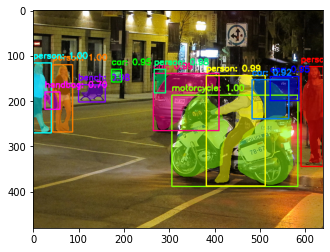

In [ ]:
model_path = "/content/drive/MyDrive/skin_cancer/assets/saved_models/"
model_name = "/content/drive/MyDrive/skin_cancer/assets/saved_models/mask_rcnn_coco.h5"
class_names = "/content/drive/MyDrive/skin_cancer/models/mask_rcnn/coco/coco_classes.txt"
image = "/content/drive/MyDrive/skin_cancer/assets/samples/moto.jpg"

my_config = MyConfig()
# my_config.display()

colors, model, classes = prepare_mrcnn_model(model_path, model_name, class_names, my_config)
output = perform_inference_image(image, model, colors, classes, draw_bbox = True, instance_segmentation = True)

# plt.imsave("result.png", output)
plt.imshow(output)
plt.show()